**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 9 - Sísmica de reflexão

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
%matplotlib inline
from IPython import display
from IPython.html import widgets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from fatiando.seismic import conv
from fatiando.seismic.wavefd import Ricker
from fatiando.vis import mpl
import fatiando
plt.rc('font', size=10)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
print(fatiando.__version__)

0.3-257-gef3ff78


## Desenhando modelos

In [5]:
def img_template(fname, pixel_thresh=10, return_colors=False):
    img = Image.open(fname)
    count, colors = zip(*[[n, c] for n, c in img.getcolors() if n > pixel_thresh])
    sort = np.argsort(count)
    colors = np.array(colors)[sort][::-1]
    data = scipy.misc.fromimage(img)
    template = np.zeros(data.shape[:2], dtype=np.int)
    for i, c in enumerate(colors):
        template[np.all(data == c, axis=2)] = i
    # For now, any pixel not of the top colors (eliminated by pixel_thresh)
    # is assigned index 0. A better way would be interpolate or copy the neighbors.
    if return_colors:
        return template, colors
    else:
        return template

In [6]:
template = img_template('meh.png')

In [7]:
def painter_widget(template, vmin, vmax, step, cmap='copper_r', prop='V', plot_func=None):
    colors = np.unique(template)
    args = dict(min=vmin, max=vmax, step=step)
    sliders = dict([['{}{}'.format(prop, i + 1), widgets.FloatSlider(**args)]
                    for i in range(len(colors))])
    model = np.empty_like(template)
    if plot_func is None:
        def plot_func(data):
            fig = plt.figure()
            ax = plt.subplot(111)
            plt.imshow(data, cmap=cmap, vmin=args['min'], vmax=args['max'])
            plt.colorbar(pad=0.01, aspect=40).set_label(prop)
            ax.set_title('Model')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            plt.tight_layout()
            return fig
    def callback(**kwargs):
        for v, c in zip(kwargs, colors):
            model[template == c] = kwargs[v]
        plot_func(model)
        return model
    return widgets.interactive(callback, **sliders)

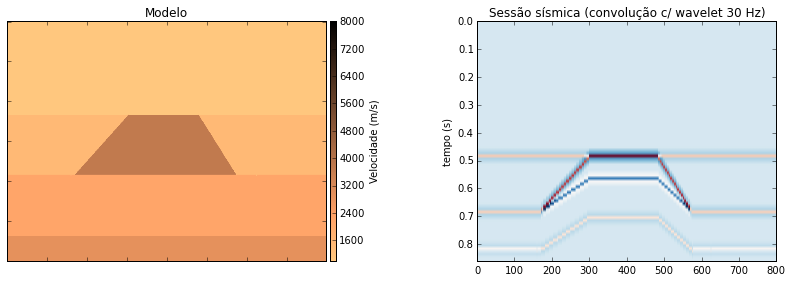

In [20]:
def plot_model_conv(vp):
    # Gardner's relation: https://en.wikipedia.org/wiki/Gardner%27s_relation
    rho = 0.31*(vp**0.25)    
    dz = 1000/vp.shape[1]
    dt = 0.01
    f = 30
    vp_t, rho_t = conv.depth_2_time(vp.shape[0], vp.shape[1], vp, dt=dt, dz=dz, rho=rho)
    data = conv.seismic_convolutional_model(vp.shape[1], vp_t, f, conv.rickerwave, dt=dt, rho=rho_t)
    times = np.arange(vp_t.shape[0])*dt
    # Plots
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(121)
    plt.imshow(vp, cmap='copper_r', vmin=1000, vmax=8000)
    plt.colorbar(pad=0.01, aspect=40).set_label('Velocidade (m/s)')
    ax.set_title('Modelo')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(122)
    mpl.seismic_image(data, dt=dt, cmap='RdBu_r')
    ax.set_title(u'Sessão sísmica (convolução c/ wavelet 30 Hz)')
    ax.set_ylabel('tempo (s)')
    plt.tight_layout()
    return fig
w = painter_widget(template, 1000, 8000, 100, plot_func=plot_model_conv)
w